In [54]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

df_basinc = pd.read_csv('/Users/ardahanaytan/Desktop/STAJ/Hava Durumu Tahmin Projesi/data/weather_datas/basinc.csv')
df_bulut = pd.read_csv('/Users/ardahanaytan/Desktop/STAJ/Hava Durumu Tahmin Projesi/data/weather_datas/bulut.csv')
df_nem = pd.read_csv('/Users/ardahanaytan/Desktop/STAJ/Hava Durumu Tahmin Projesi/data/weather_datas/nem.csv')
df_ruzgar = pd.read_csv('/Users/ardahanaytan/Desktop/STAJ/Hava Durumu Tahmin Projesi/data/weather_datas/ruzgar_hizi_yonu.csv')
df_sicaklik = pd.read_csv('/Users/ardahanaytan/Desktop/STAJ/Hava Durumu Tahmin Projesi/data/weather_datas/sicaklik.csv')
df_yagmur = pd.read_csv('/Users/ardahanaytan/Desktop/STAJ/Hava Durumu Tahmin Projesi/data/weather_datas/yagmur.csv')
df_kar = pd.read_csv('/Users/ardahanaytan/Desktop/STAJ/Hava Durumu Tahmin Projesi/data/weather_datas/kar.csv')

ctable = ['Basinc','Bulut','Nem','Ruzgar Hizi','Ruzgar Yonu','Sicaklik','Yagis','Kar']
tables = [df_nem, df_ruzgar, df_sicaklik, df_yagmur, df_kar]
real_df = pd.merge(df_basinc, df_bulut, on = ['Yil', 'Ay', 'Gun', 'Saat'])

for i in tables:
    real_df = pd.merge(real_df, i, on = ['Yil', 'Ay', 'Gun', 'Saat'])

df = real_df.copy()
df = df.dropna()

df['Yil'] = df['Yil'].str[1:].astype(int)
df['Ay'] = df['Ay'].map({
    'Ocak': 1, 'Şubat': 2, 'Mart': 3, 'Nisan': 4, 'Mayıs': 5, 'Haziran': 6,
    'Temmuz': 7, 'Ağustos': 8, 'Eylül': 9, 'Ekim': 10, 'Kasım': 11, 'Aralık': 12
})
df['Gun'] = df['Gun'].str[1:].astype(int)
df['Saat'] = df['Saat'].str[1:].str[:2].astype(int)

df['datetime'] = pd.to_datetime(df[['Yil', 'Ay', 'Gun']].astype(str).agg('-'.join, axis=1) + ' ' + df['Saat'].astype(str), format='%Y-%m-%d %H')
df.set_index('datetime', inplace=True)
df.drop(columns=['Yil', 'Ay', 'Gun', 'Saat'], inplace=True)
df.columns = ctable

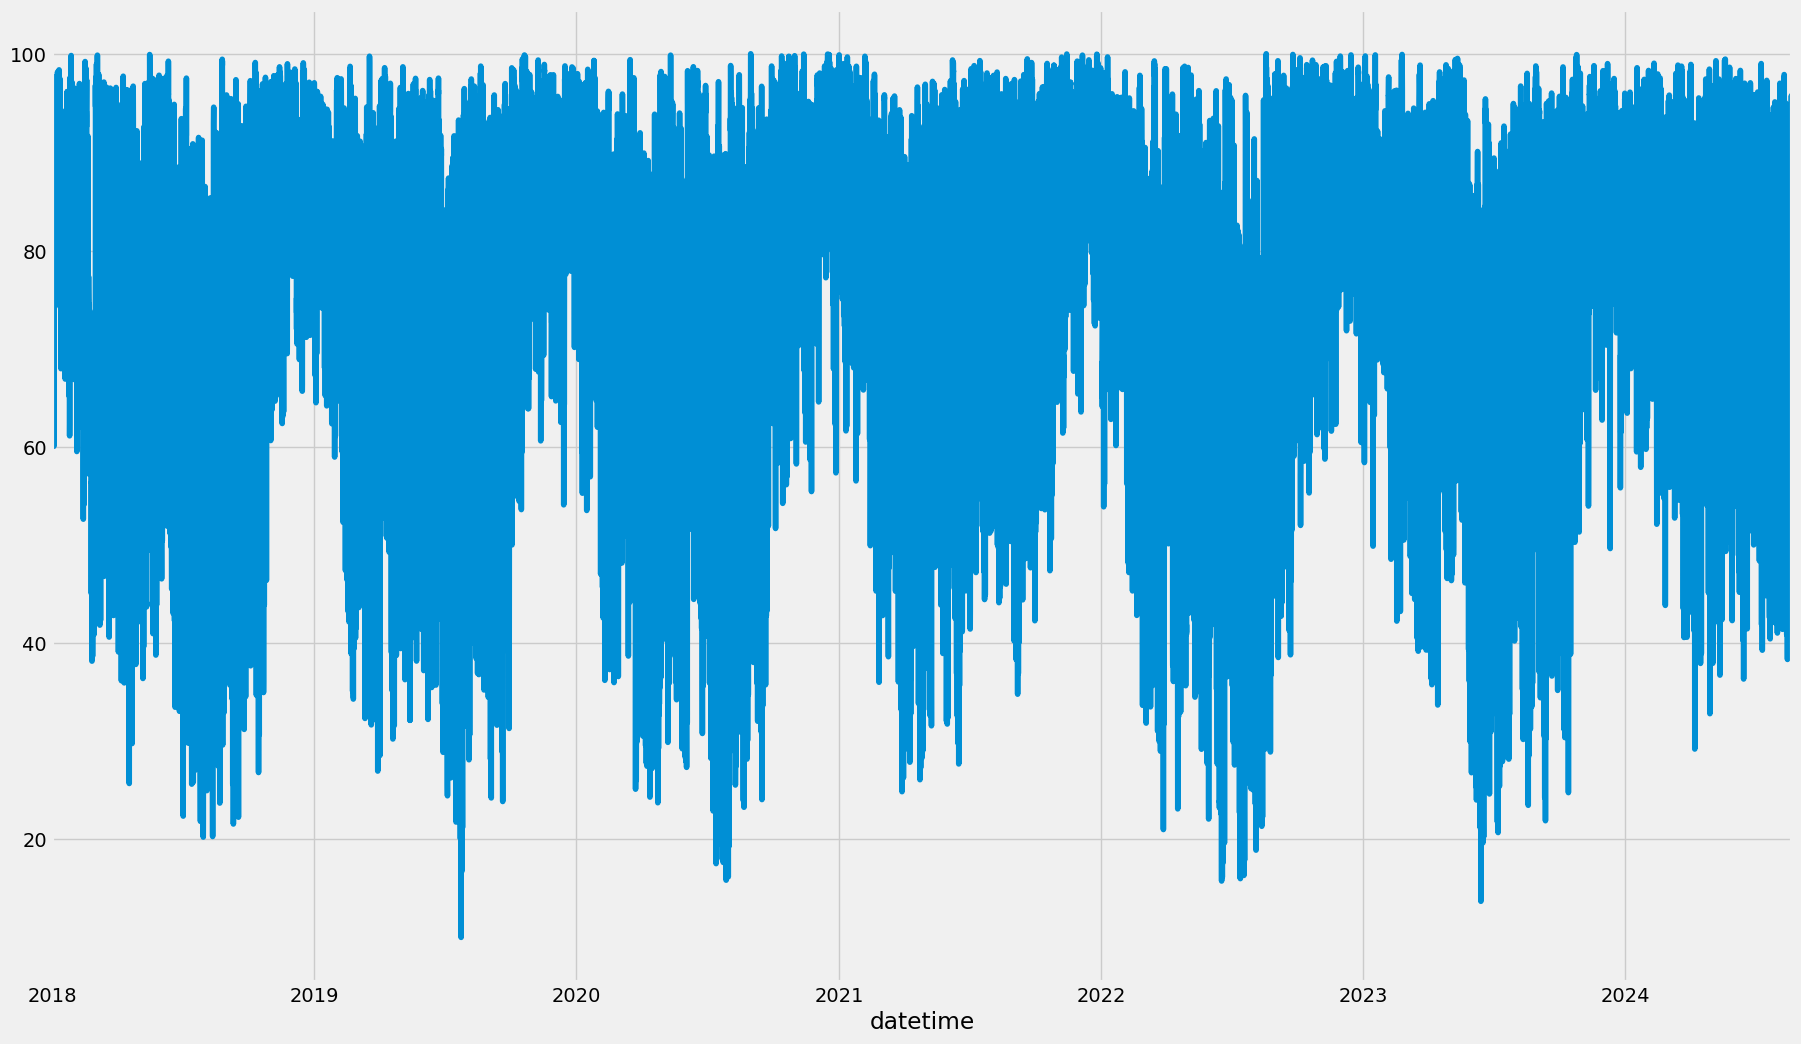

In [69]:
df.Nem.plot(subplots=True, figsize=(20,12));

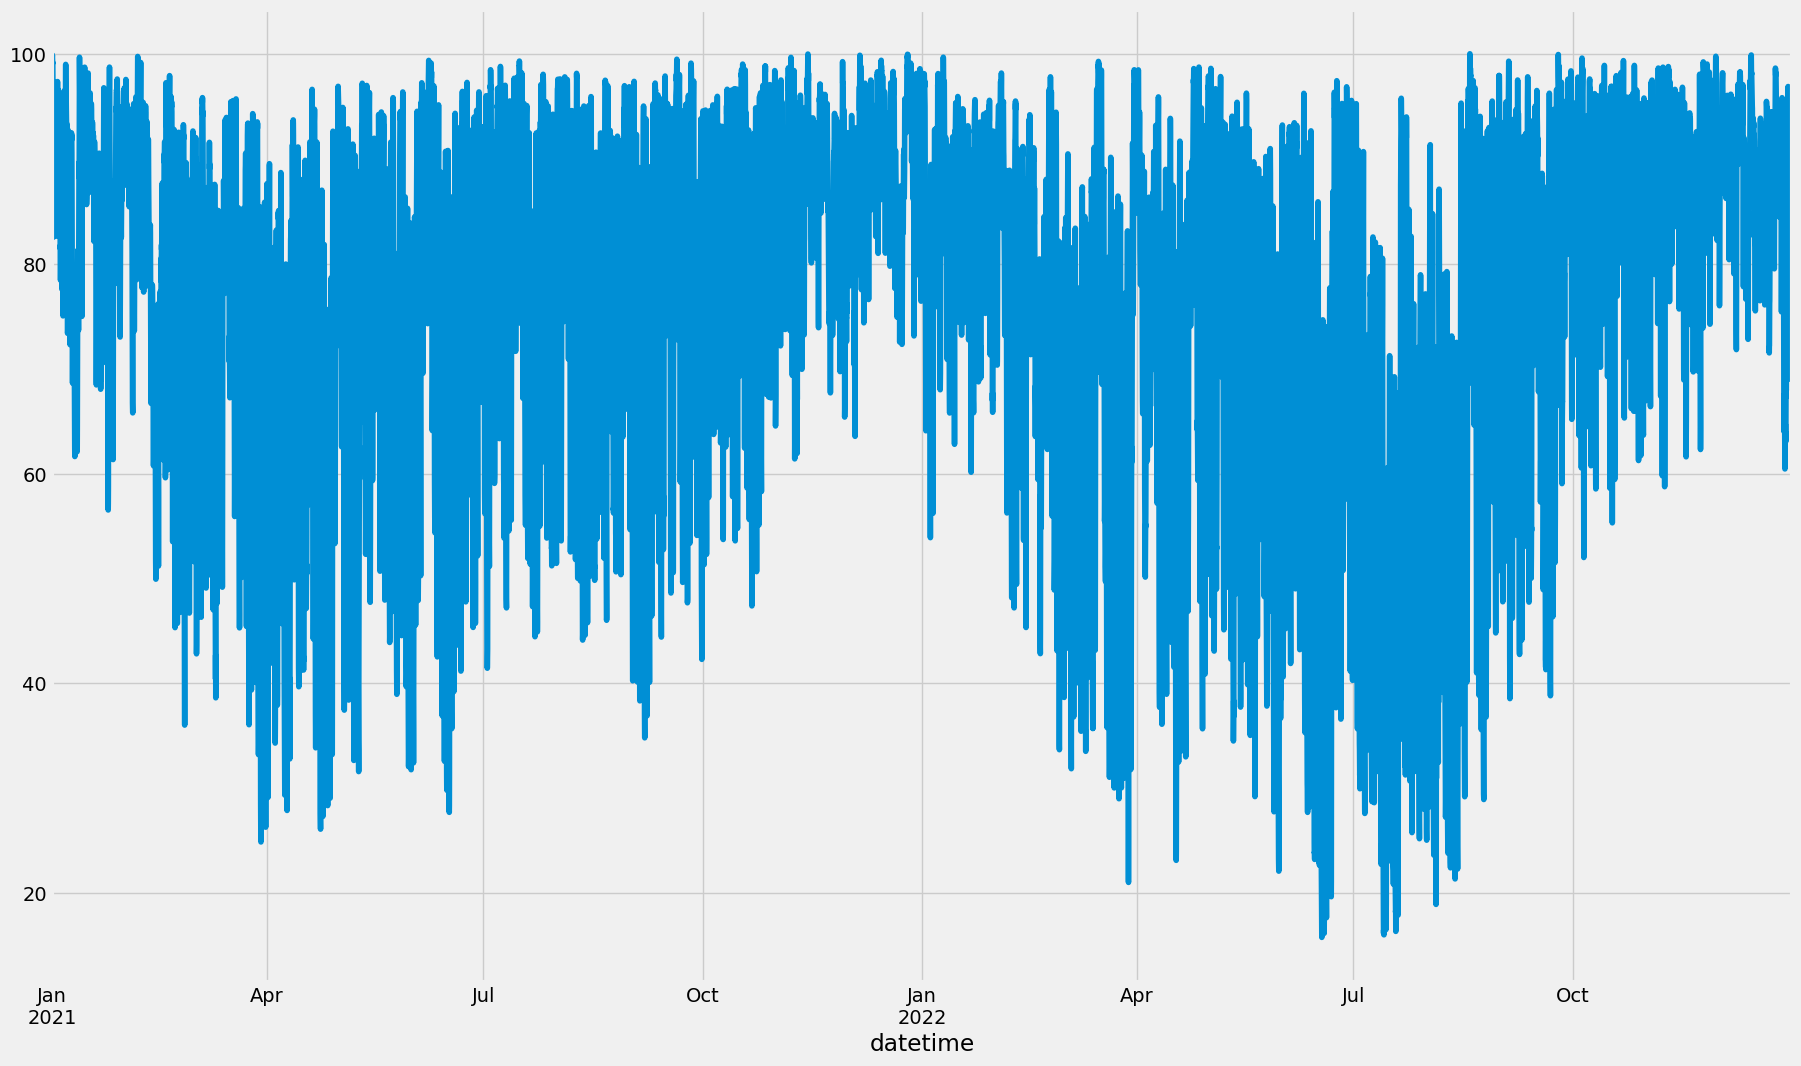

In [67]:
df.Nem['2021':'2022'].resample('D')
df.Nem['2021':'2022'].plot(subplots=True, figsize=(20,12));

In [71]:
df_t = pd.DataFrame({'Nem': df['Nem']})

train_df = df_t[:int(0.8 * len(df.index))].resample('M').mean()
test_df = df_t[int(0.8 * len(df.index)):].resample('M').mean()

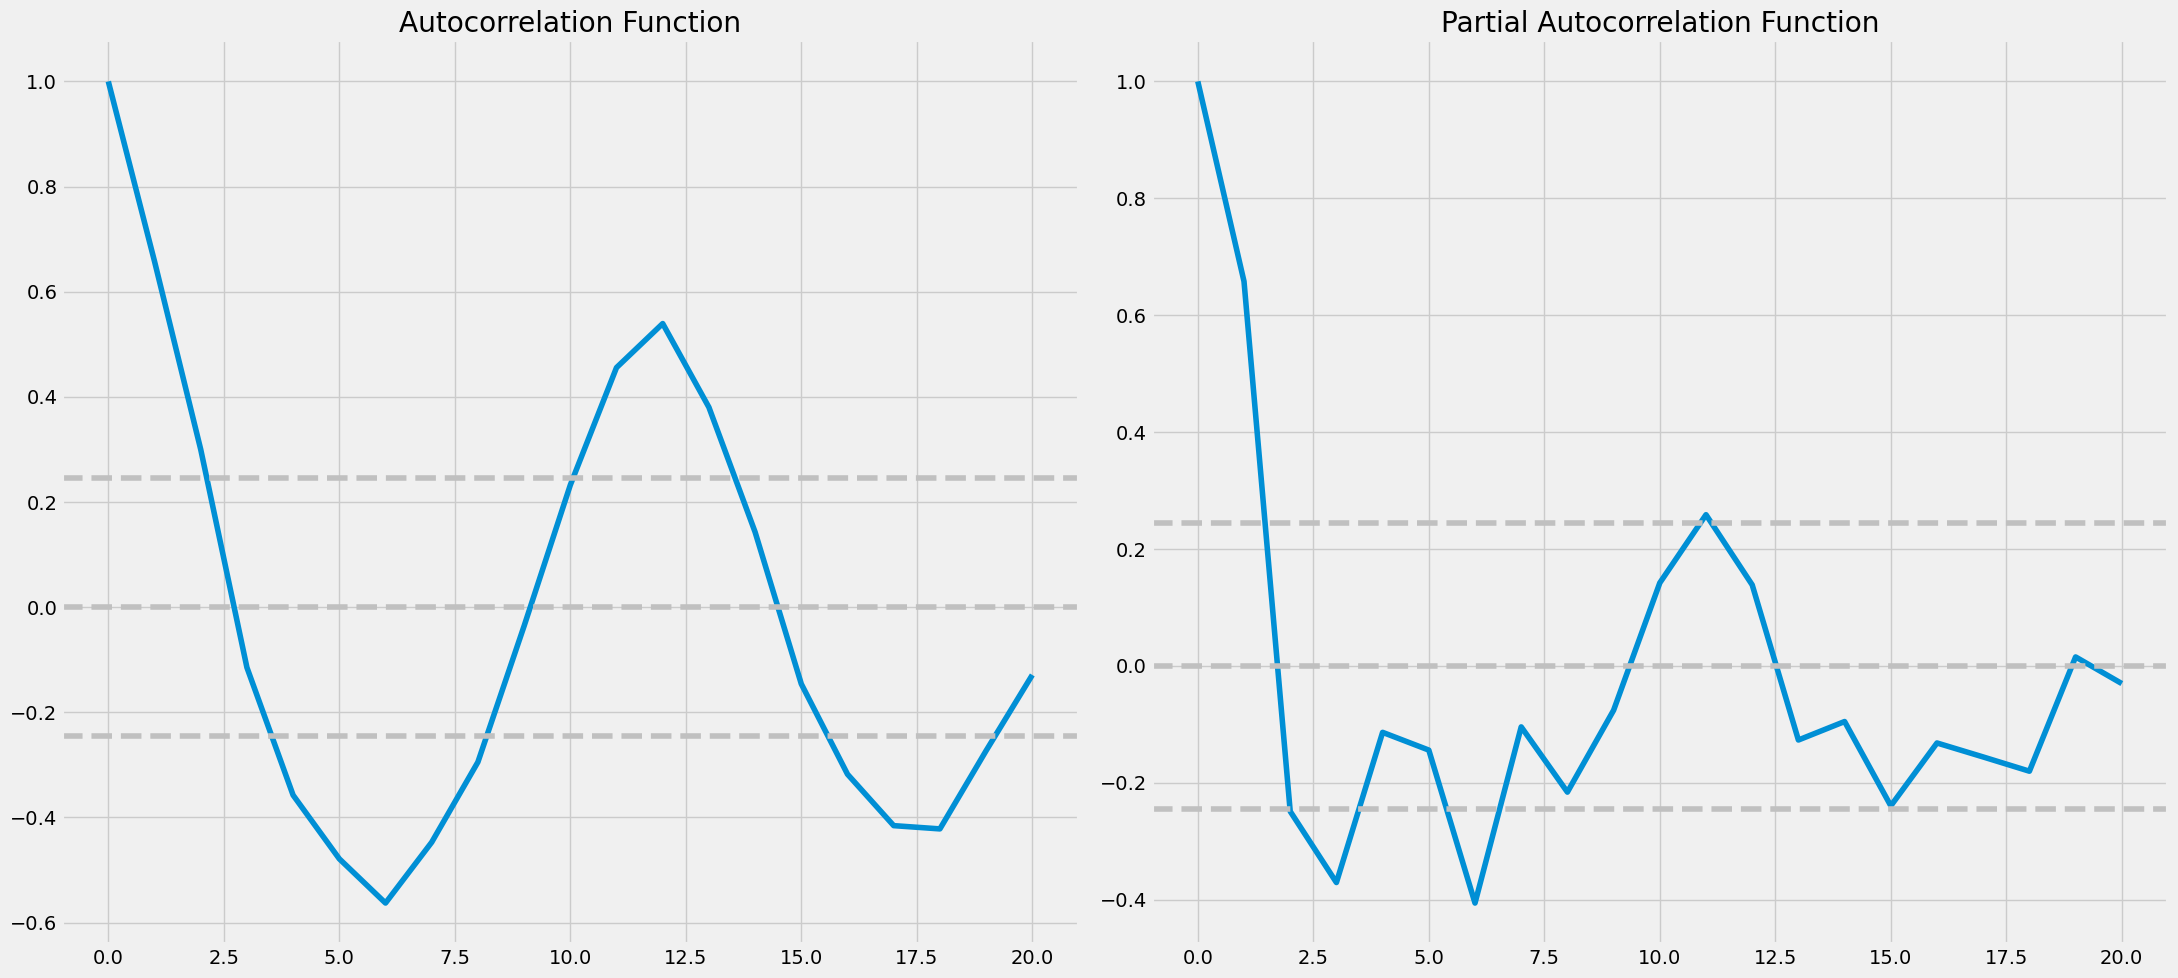

In [72]:
acf_lag = acf(train_df.values, nlags=20)
pacf_lag = pacf(train_df.values, nlags=20, method='ols')

plt.figure(figsize=(22,10))

plt.subplot(1,2,1)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.title("Autocorrelation Function")

plt.subplot(1,2,2)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

In [73]:
model = ARIMA(train_df.values, order=(2,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   64
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -208.330
Date:                Thu, 29 Aug 2024   AIC                            426.660
Time:                        16:13:56   BIC                            437.454
Sample:                             0   HQIC                           430.912
                                 - 64                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         75.1377      0.444    169.171      0.000      74.267      76.008
ar.L1          1.5513      0.111     13.960      0.000       1.333       1.769
ar.L2         -0.7657      0.115     -6.640      0.0

/Users/ardahanaytan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ardahanaytan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


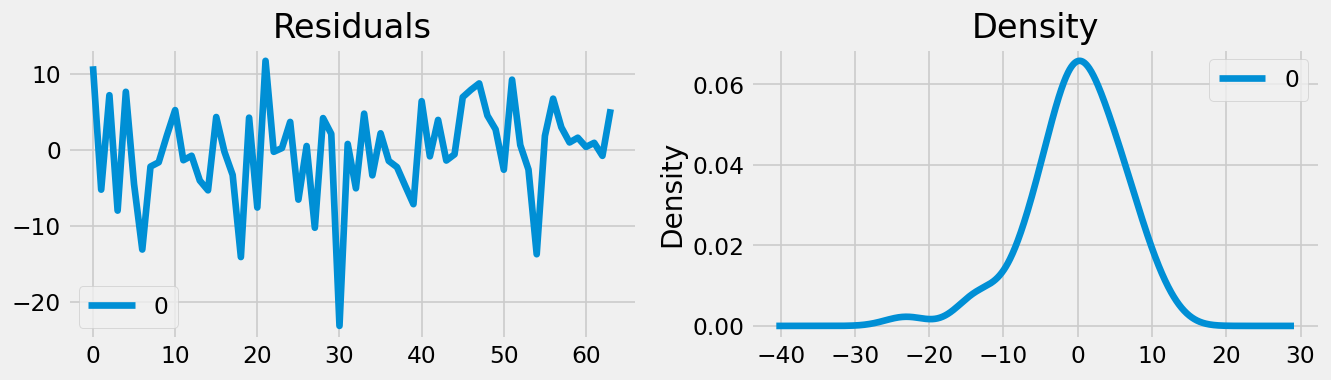

In [74]:
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [79]:
forecast_results = model_fit.get_forecast(16, alpha=0.05)
fc = forecast_results.predicted_mean
conf = forecast_results.conf_int()

fc_series = pd.Series(fc, index=test_df.index)
lower_series = pd.Series(conf[:, 0], index=test_df.index)
upper_series = pd.Series(conf[:, 1], index=test_df.index)
'''
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_df, label='training')
plt.plot(test_df, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
'''

ValueError: Length of values (16) does not match length of index (17)